**Objective**
**Business Objective:**

“Will a customer accept the coupon?” The goal of this project is to use what you know about visualizations and probability distributions to distinguish between customers who accepted a driving coupon versus those who did not. Use the Practical Application 1 Jupyter Notebook Links to an external site.to complete this assignment.

## **Getting started**

In [3]:
import os

files = os.listdir('/content/')
print(files)


['.config', 'sample_data']


In [4]:
# upload data files
from google.colab import files
uploaded = files.upload()  # Opens a file selection dialog


Saving coupons.csv to coupons.csv


In [5]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import missingno as msno
import datetime as dt

In [6]:
# Read in the dataset
cpn = pd.read_csv('/content/coupons.csv')

Overall Correlation with Y:
Y                    1.000000
toCoupon_GEQ25min    0.053682
direction_same      -0.002065
toCoupon_GEQ15min   -0.034143
temperature         -0.039738
age                 -0.239270
toCoupon_GEQ5min          NaN
Name: Y, dtype: float64

Features sorted by absolute correlation with Y:
age                  0.239270
toCoupon_GEQ25min    0.053682
temperature          0.039738
toCoupon_GEQ15min    0.034143
direction_same       0.002065
toCoupon_GEQ5min          NaN
Name: Y, dtype: float64


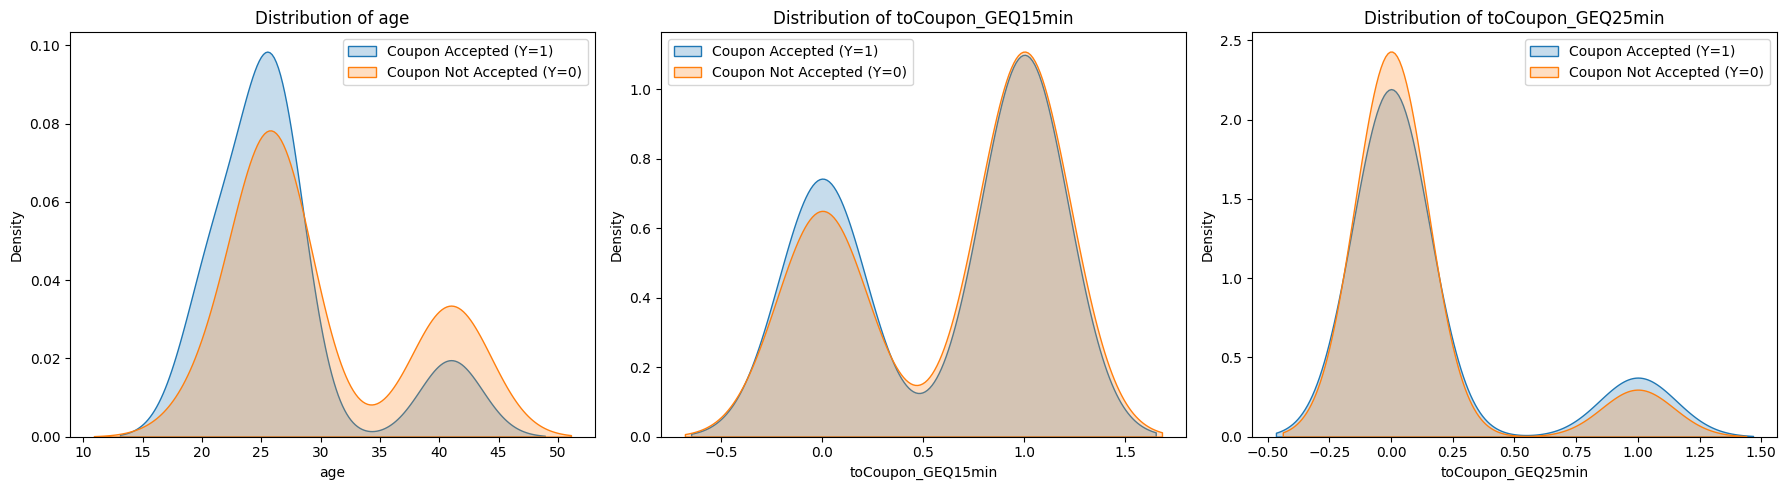


Features sorted by correlation with Y (ascending):
age                 -0.239270
temperature         -0.039738
toCoupon_GEQ15min   -0.034143
direction_same      -0.002065
toCoupon_GEQ25min    0.053682
toCoupon_GEQ5min          NaN
Name: Y, dtype: float64

Top 3 features most correlated with coupon not accepted (Y=0):
age                 -0.239270
temperature         -0.039738
toCoupon_GEQ15min   -0.034143
Name: Y, dtype: float64


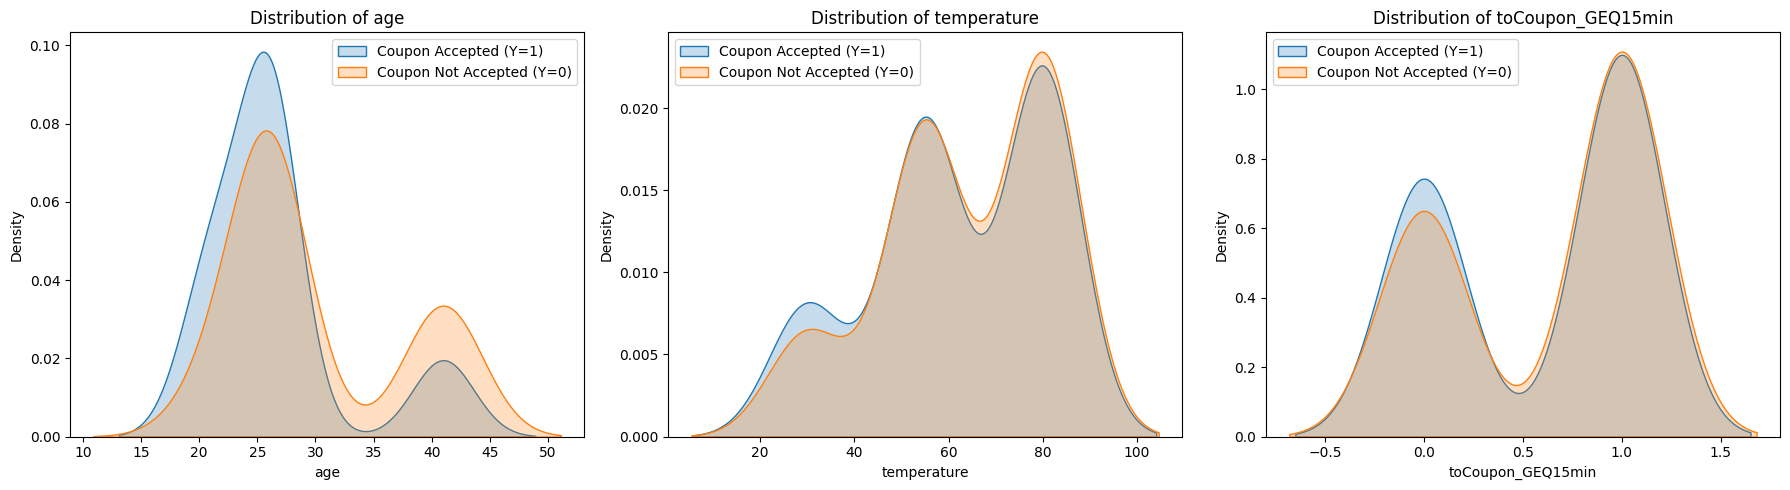

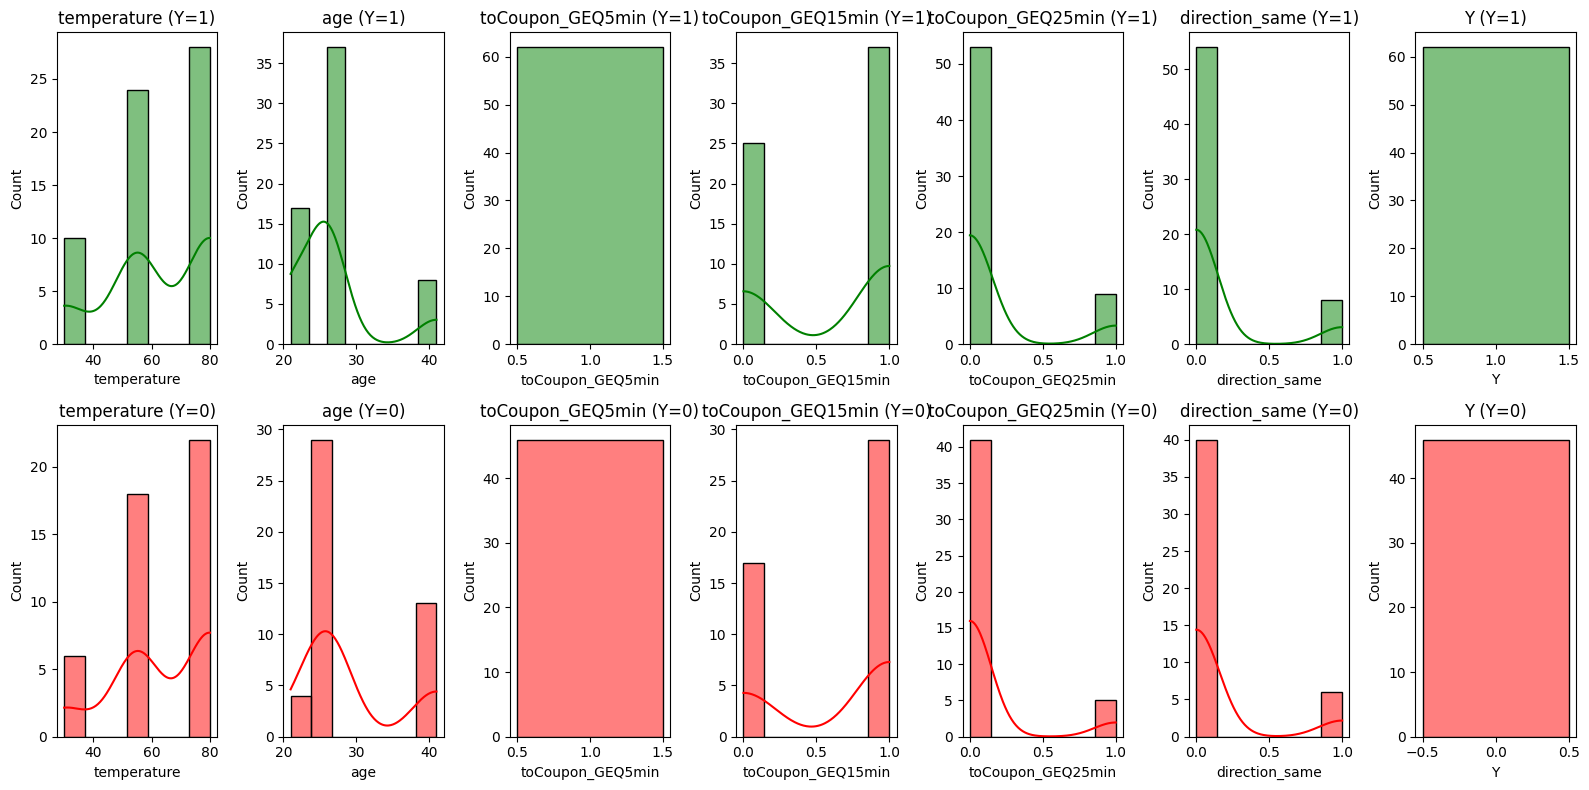

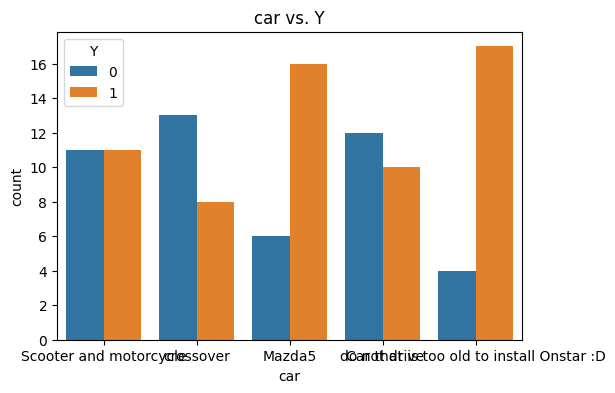

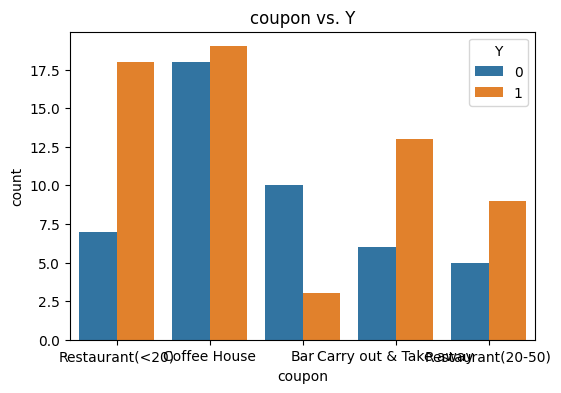

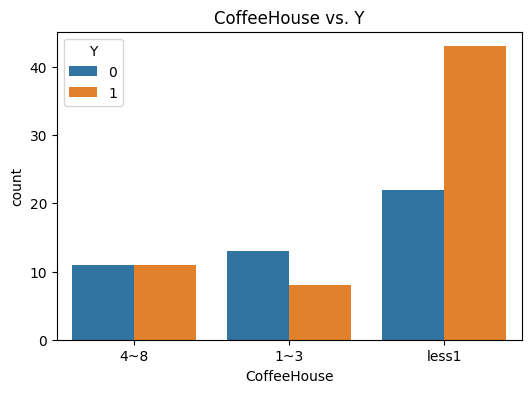

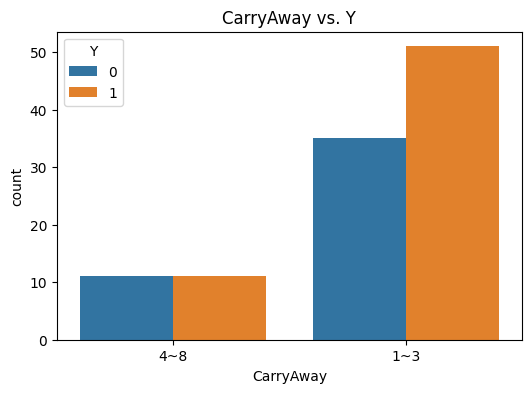

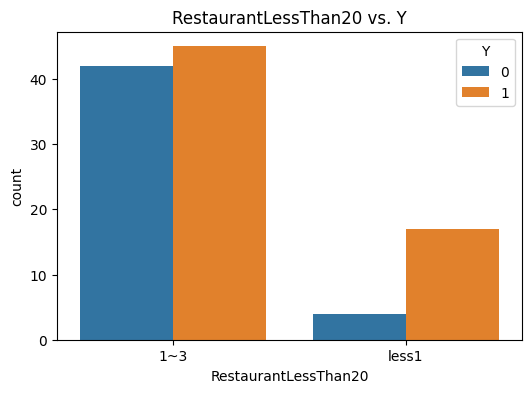

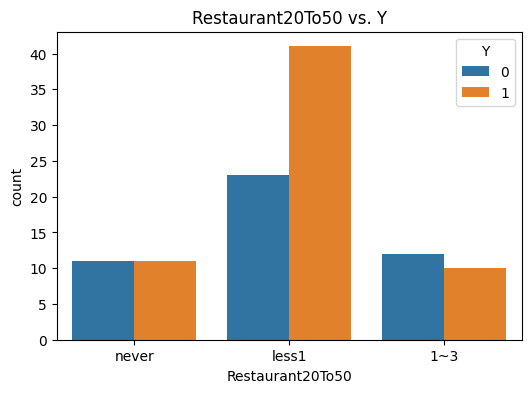

In [8]:


# Remove rows with missing values in key columns
key_columns = [
    'car', 'Bar', 'coupon', 'CoffeeHouse', 'CarryAway',
    'RestaurantLessThan20', 'Restaurant20To50', 'temperature',
    'age', 'toCoupon_GEQ5min', 'toCoupon_GEQ15min', 'toCoupon_GEQ25min',
    'direction_same', 'Y'
]
cpn = cpn.dropna(subset=key_columns).copy()
cpn = cpn.drop_duplicates().copy()

# Define numeric columns
numeric_cols = [
    'temperature', 'age', 'toCoupon_GEQ5min', 'toCoupon_GEQ15min',
    'toCoupon_GEQ25min', 'direction_same', 'Y'
]

# Force numeric conversion for specified columns
for col in numeric_cols:
    cpn[col] = pd.to_numeric(cpn[col], errors='coerce')

# -----------------------
# Split Data by Coupon Acceptance (Y)
# -----------------------
cpnYes = cpn[cpn['Y'] == 1].copy()
cpnNo  = cpn[cpn['Y'] == 0].copy()

# -----------------------
# Outlier Capping (1st to 99th percentiles)
# -----------------------
# For Coupon Accepted (Y=1)
for col in numeric_cols:
    lower_cap = cpnYes[col].quantile(0.01)
    upper_cap = cpnYes[col].quantile(0.99)
    cpnYes[col] = cpnYes[col].clip(lower_cap, upper_cap)

# For Coupon Not Accepted (Y=0)
for col in numeric_cols:
    lower_cap = cpnNo[col].quantile(0.01)
    upper_cap = cpnNo[col].quantile(0.99)
    cpnNo[col] = cpnNo[col].clip(lower_cap, upper_cap)

# -----------------------
# Overall Correlation Analysis for Coupon Accepted (Y)
# -----------------------
corr_matrix = cpn[numeric_cols].corr()
print("Overall Correlation with Y:")
print(corr_matrix['Y'].sort_values(ascending=False))

# Identify the highest correlated features with Y by absolute correlation
corr_features = corr_matrix['Y'].drop('Y').abs()
sorted_corr = corr_features.sort_values(ascending=False)
print("\nFeatures sorted by absolute correlation with Y:")
print(sorted_corr)

# Based on the printed results, we have:
# Highest: 'age'
# Second Highest: 'toCoupon_GEQ15min'
# Third Highest: 'toCoupon_GEQ25min'
features_to_plot = ['age', 'toCoupon_GEQ15min', 'toCoupon_GEQ25min']

# -----------------------
# Visualization: Plot distributions of top correlated features for Coupon Accepted vs. Not Accepted
# -----------------------
plt.figure(figsize=(18, 5))
for i, feature in enumerate(features_to_plot):
    plt.subplot(1, 3, i+1)
    sns.kdeplot(data=cpnYes, x=feature, label='Coupon Accepted (Y=1)', fill=True)
    sns.kdeplot(data=cpnNo,  x=feature, label='Coupon Not Accepted (Y=0)', fill=True)
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend()

plt.tight_layout()
plt.savefig("./top3_accepting.png")  # Save plot for top 3 features correlated with accepting
plt.show()

# -----------------------
# Overall Correlation Analysis for Coupon Not Accepted (Y=0)
# -----------------------
# Since Y is 1 for coupon accepted, a negative correlation with Y means the feature is higher when Y=0.
negative_corr_features = corr_matrix['Y'].drop('Y').sort_values()
print("\nFeatures sorted by correlation with Y (ascending):")
print(negative_corr_features)

# The top 3 features most correlated with NOT accepting a coupon (i.e. most negative correlations)
top3_not_accept = negative_corr_features.head(3)
print("\nTop 3 features most correlated with coupon not accepted (Y=0):")
print(top3_not_accept)

# -----------------------
# Visualization: Plot distributions for the top 3 features associated with Coupon Not Accepted
# -----------------------
features_to_plot_not_accept = top3_not_accept.index.tolist()
plt.figure(figsize=(18, 5))
for i, feature in enumerate(features_to_plot_not_accept):
    plt.subplot(1, 3, i+1)
    sns.kdeplot(data=cpnYes, x=feature, label='Coupon Accepted (Y=1)', fill=True)
    sns.kdeplot(data=cpnNo,  x=feature, label='Coupon Not Accepted (Y=0)', fill=True)
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend()

plt.tight_layout()
plt.savefig("./top3_not_accepting.png")  # Save plot for top 3 features correlated with not accepting
plt.show()

# detail feature exploration

fig, axes = plt.subplots(nrows=2, ncols=len(numeric_cols), figsize=(16, 8))

for i, col in enumerate(numeric_cols):
    sns.histplot(cpnYes[col], ax=axes[0, i], kde=True, color='green')
    axes[0, i].set_title(f"{col} (Y=1)")

    sns.histplot(cpnNo[col], ax=axes[1, i], kde=True, color='red')
    axes[1, i].set_title(f"{col} (Y=0)")

plt.tight_layout()
plt.show()


cat_cols = ['car', 'coupon', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50']

for col in cat_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(x=col, hue='Y', data=cpn)
    plt.title(f"{col} vs. Y")
    plt.show()


In [ ]:
# Visualize distribution of Age
# cpn['age'] = cpn['age'].str.strip("plus")
# cpn['age'] = cpn['age'].str.strip("below")
# cpn['age'].unique()  #['21', '46', '26', '31', '41', '50plus', '36', 'below21']
# cpn['age'] = cpn['age'].astype('float')
# sns.distplot(cpn['age'], bins = 20)
# plt.show()

cpn.head()

# cpnage = cpn[['car', 'coupon']].dropna().copy()

# sns.cov(cpnage)
# sns.heapmap(cpnage)
# sns.heatmap(cpnage.cov(), annot=True, cmap='coolwarm')
# plt.show()

# car
# Bar
# CoffeeHouse
# CarryAway
# RestaurantLessThan20
# Restaurant20To50

# cpn.dtype

# cpn_clean = cpn.dropna(subset=['car','Bar', 'coupon','CoffeeHouse','CarryAway','RestaurantLessThan20', 'Restaurant20To50'  ])

# sns.boxplot(x='car', y='coupon', data=cpn_clean)
# plt.title("Coupon Distribution by Car Category")
# plt.show()

# cpn_clean = cpn.dropna(subset=['Bar', 'coupon'])
# sns.boxplot(x='Bar', y='coupon', data=cpn_clean)
# plt.title("Coupon Distribution by Bar Category")
# plt.show()

# cpn_clean = cpn.dropna(subset=['CoffeeHouse', 'coupon'])
# sns.boxplot(x='CoffeeHouse', y='coupon', data=cpn_clean)
# plt.title("Coupon Distribution by CoffeeHouse Category")
# plt.show()


# sns.scatterplot(x='car', y='coupon', data=cpn_clean)
# plt.title("Coupon Distribution by Car Category")
# plt.show()

# cpn_clean = cpn.dropna(subset=['Bar', 'coupon'])
# sns.scatterplot(x='Bar', y='coupon', data=cpn_clean)
# plt.title("Coupon Distribution by Bar Category")
# plt.show()

# cpn_clean = cpn.dropna(subset=['CoffeeHouse', 'coupon'])
# sns.scatterplot(x='CoffeeHouse', y='coupon', data=cpn_clean)
# plt.title("Coupon Distribution by CoffeeHouse Category")
# plt.show()

# sns.lineplot(x='car', y='coupon', data=cpn_clean)
# plt.title("Coupon Distribution by Car Category")
# plt.show()

# cpn_clean = cpn.dropna(subset=['Bar', 'coupon'])
# sns.lineplot(x='Bar', y='coupon', data=cpn_clean)
# plt.title("Coupon Distribution by Bar Category")
# plt.show()

# cpn_clean = cpn.dropna(subset=['CoffeeHouse', 'coupon'])
# sns.lineplot(x='CoffeeHouse', y='coupon', data=cpn_clean)
# plt.title("Coupon Distribution by CoffeeHouse Category")
# plt.show()




##### **Task 3:** Convert `listing_added` and `last_review` columns to `datetime`

To perform this task, we will use the following functions:

- `pd.to_datetime(format = "")`
  - `format` takes in the desired date format `"%Y-%m-%d"`

In [ ]:
# Convert both columns to datetime
airbnb['listing_added'] = pd.to_datetime(airbnb['listing_added'], format = '%Y-%m-%d')
airbnb['last_review'] = pd.to_datetime(airbnb['last_review'], format = '%Y-%m-%d')

In [ ]:
# Print header and datatypes of both columns again
print(airbnb[['listing_added', 'last_review']].head())
print(airbnb[['listing_added', 'last_review']].dtypes)

  listing_added last_review
0    2018-06-08  2018-12-12
1    2018-12-25  2019-06-30
2    2018-08-15         NaT
3    2017-03-20  2017-09-23
4    2020-10-23  2019-06-12
listing_added    datetime64[ns]
last_review      datetime64[ns]
dtype: object


### Text and categorical data problems

##### **Task 4:** We need to collapse `room_type` into correct categories

To perform this task, we will be using the following methods:

- `.str.lower()` to lowercase all rows in a string column
- `.str.strip()` to remove all white spaces of each row in a string column
- `.replace()` to replace values in a column with another

In [ ]:
# Print unique values of `room_type`
airbnb['room_type'].unique()

array(['Private room', 'Entire home/apt', 'Private', 'Shared room',
       'PRIVATE ROOM', 'home', '   Shared room      '], dtype=object)

In [ ]:
# Deal with capitalized values
airbnb['room_type'] = airbnb['room_type'].str.lower()
airbnb['room_type'].unique()

array(['private room', 'entire home/apt', 'private', 'shared room',
       'home', '   shared room      '], dtype=object)

In [ ]:
# Deal with trailing spaces
airbnb['room_type'] = airbnb['room_type'].str.strip()
airbnb['room_type'].unique()

array(['private room', 'entire home/apt', 'private', 'shared room',
       'home'], dtype=object)

In [ ]:
# Replace values to 'Shared room', 'Entire place', 'Private room' and 'Hotel room' (if applicable).
mappings = {'private room': 'Private Room',
            'private': 'Private Room',
            'entire home/apt': 'Entire place',
            'shared room': 'Shared room',
            'home': 'Entire place'}

# Replace values and collapse data
airbnb['room_type'] = airbnb['room_type'].replace(mappings)
airbnb['room_type'].unique()

array(['Private Room', 'Entire place', 'Shared room'], dtype=object)

##### **Task 5:** Divide `neighbourhood_full` into 2 columns and making sure they are clean

In [ ]:
# Print header of column
airbnb['neighbourhood_full'].head()

0           Brooklyn, Flatlands
1    Manhattan, Upper West Side
2    Brooklyn, Brooklyn Heights
3    Manhattan, Upper West Side
4    Manhattan, Lower East Side
Name: neighbourhood_full, dtype: object

In [ ]:
# Split neighbourhood_full
borough_neighbourhood = airbnb['neighbourhood_full'].str.split(",", expand = True)
borough_neighbourhood.head()

,0,1
0,Brooklyn,Flatlands
1,Manhattan,Upper West Side
2,Brooklyn,Brooklyn Heights
3,Manhattan,Upper West Side
4,Manhattan,Lower East Side


In [ ]:
# Create borough and neighbourhood columns
airbnb['borough'] = borough_neighbourhood[0]
airbnb['neighbourhood'] = borough_neighbourhood[1]
# Print header of columns
airbnb[['neighbourhood_full', 'borough', 'neighbourhood']].head()

,neighbourhood_full,borough,neighbourhood
0,"Brooklyn, Flatlands",Brooklyn,Flatlands
1,"Manhattan, Upper West Side",Manhattan,Upper West Side
2,"Brooklyn, Brooklyn Heights",Brooklyn,Brooklyn Heights
3,"Manhattan, Upper West Side",Manhattan,Upper West Side
4,"Manhattan, Lower East Side",Manhattan,Lower East Side


In [ ]:
# Drop neighbourhood_full column
airbnb.drop('neighbourhood_full', axis = 1, inplace = True)

In [ ]:
# Print out unique values of borough and neighbourhood
print(airbnb['borough'].unique())
print(airbnb['neighbourhood'].unique())

['Brooklyn' 'Manhattan' 'Queens' 'Bronx' 'Staten Island']
[' Flatlands' ' Upper West Side' ' Brooklyn Heights' ' Lower East Side'
 ' Greenwich Village' ' Harlem' ' Sheepshead Bay' ' Theater District'
 ' Bushwick' ' Laurelton' ' Mott Haven' ' Flushing' ' Crown Heights'
 ' Midtown' ' Financial District' ' East Village' ' Park Slope'
 ' Washington Heights' ' Williamsburg' ' Chelsea' ' Bedford-Stuyvesant'
 ' Gowanus' ' Upper East Side' ' Ditmars Steinway' ' Cypress Hills'
 " Hell's Kitchen" ' Ridgewood' ' Marble Hill' ' Kips Bay'
 ' Prospect Heights' ' East New York' ' Concord' ' Stapleton' ' Astoria'
 ' East Harlem' ' Sunnyside' ' Gramercy' ' Prospect-Lefferts Gardens'
 ' Sunset Park' ' Forest Hills' ' Windsor Terrace' ' Clinton Hill'
 ' Murray Hill' ' Flatiron District' ' Greenpoint' ' East Flatbush'
 ' Tribeca' ' Woodhaven' ' Fort Greene' ' Inwood' ' Chinatown'
 ' Rockaway Beach' ' Woodside' ' Bayside' ' Bensonhurst' ' SoHo'
 ' Red Hook' ' West Village' ' South Slope' ' Richmond Hill' '

In [ ]:
# Strip white space from neighbourhood column
airbnb['neighbourhood'] = airbnb['neighbourhood'].str.strip()
# Print unique values again
print(airbnb['neighbourhood'].unique())

['Flatlands' 'Upper West Side' 'Brooklyn Heights' 'Lower East Side'
 'Greenwich Village' 'Harlem' 'Sheepshead Bay' 'Theater District'
 'Bushwick' 'Laurelton' 'Mott Haven' 'Flushing' 'Crown Heights' 'Midtown'
 'Financial District' 'East Village' 'Park Slope' 'Washington Heights'
 'Williamsburg' 'Chelsea' 'Bedford-Stuyvesant' 'Gowanus' 'Upper East Side'
 'Ditmars Steinway' 'Cypress Hills' "Hell's Kitchen" 'Ridgewood'
 'Marble Hill' 'Kips Bay' 'Prospect Heights' 'East New York' 'Concord'
 'Stapleton' 'Astoria' 'East Harlem' 'Sunnyside' 'Gramercy'
 'Prospect-Lefferts Gardens' 'Sunset Park' 'Forest Hills'
 'Windsor Terrace' 'Clinton Hill' 'Murray Hill' 'Flatiron District'
 'Greenpoint' 'East Flatbush' 'Tribeca' 'Woodhaven' 'Fort Greene' 'Inwood'
 'Chinatown' 'Rockaway Beach' 'Woodside' 'Bayside' 'Bensonhurst' 'SoHo'
 'Red Hook' 'West Village' 'South Slope' 'Richmond Hill' 'Jamaica'
 'Boerum Hill' 'St. George' 'Clason Point' 'College Point' 'Vinegar Hill'
 'Rego Park' 'East Elmhurst' 'Kensin

##### **Task 6:** Make sure we set the correct maximum for `rating` column out of range values

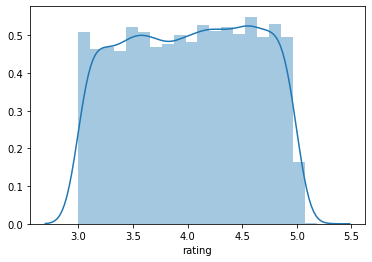

In [ ]:
# Visualize the rating column again
sns.distplot(airbnb['rating'], bins = 20)
plt.show()

In [ ]:
# Isolate rows of rating > 5.0
airbnb[airbnb['rating'] > 5.0]

,listing_id,name,host_id,host_name,room_type,price,number_of_reviews,last_review,reviews_per_month,availability_365,rating,number_of_stays,5_stars,listing_added,latitude,longitude,borough,neighbourhood
1925,36411407,Brand new 1 bedroom steps from Soho!,33917435,Mike,Entire place,150.0,1,2019-07-06,1.0,13,5.017040,1.2,0.870161,2018-12-31,40.71825,-73.99019,Manhattan,Lower East Side
6732,36390226,Comfortable clean Bedstuy private room,267932490,Angela,Private Room,45.0,2,2019-07-08,2.0,14,5.087091,2.4,0.950339,2019-01-02,40.69551,-73.93951,Brooklyn,Bedford-Stuyvesant
8821,36413632,Spacious 2BR in Beautiful Brooklyn Heights,6608220,Matt,Entire place,550.0,1,2019-07-07,1.0,230,5.181114,1.2,0.805418,2019-01-01,40.69827,-73.99649,Brooklyn,Brooklyn Heights


In [ ]:
# Drop these rows and make sure we have effected changes
airbnb.drop(airbnb[airbnb['rating'] > 5.0].index, inplace = True)

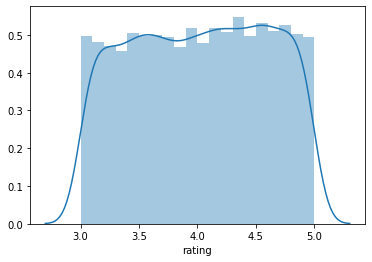

In [ ]:
# Visualize the rating column again
sns.distplot(airbnb['rating'], bins = 20)
plt.show()

In [ ]:
# Get the maximum
airbnb['rating'].max()

4.999561104773598

## **Q&A**

### Dealing with missing data

The `missingno` (imported as `msno`) package is great for visualizing missing data - we will be using:

- `msno.matrix()` visualizes a missingness matrix
- `msno.bar()` visualizes a missngness barplot
- `plt.show()` to show the plot

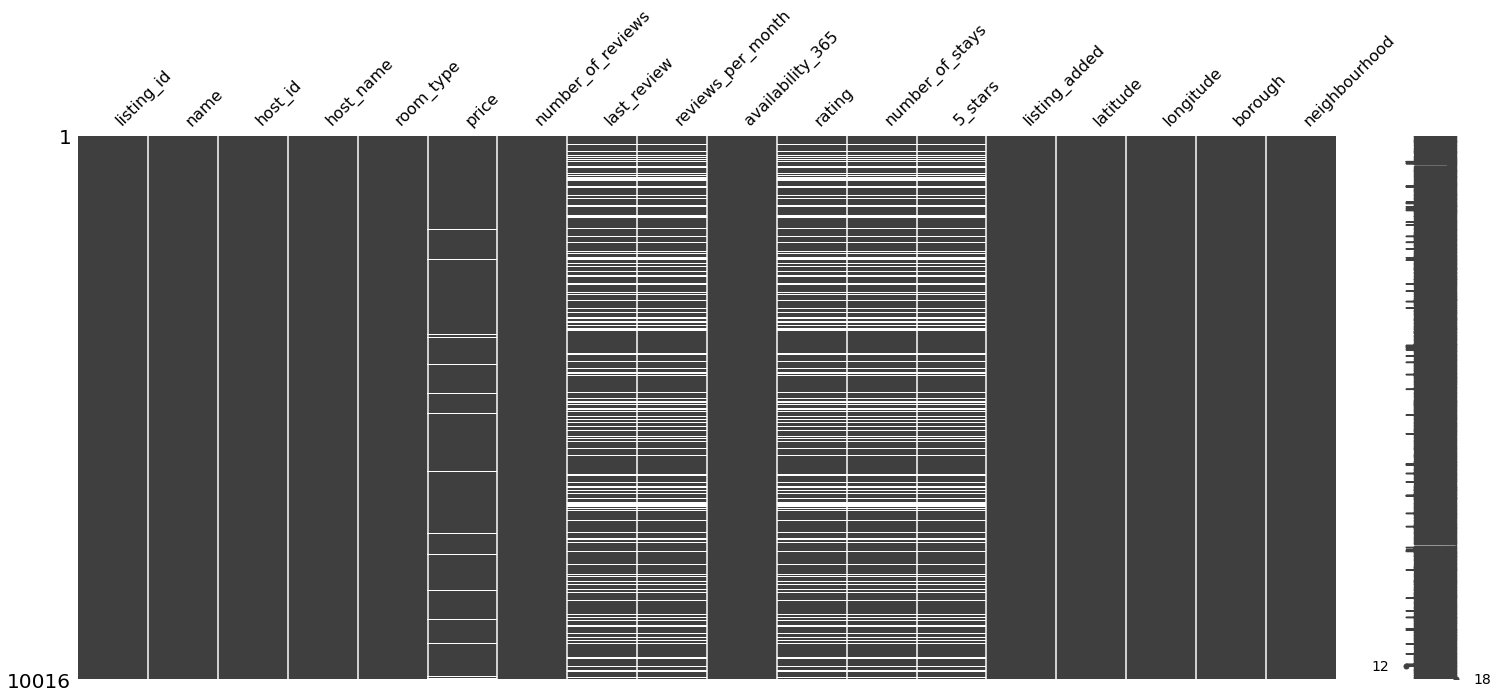

In [ ]:
# Visualize the missingness
msno.matrix(airbnb)
plt.show()

Looking at the missingness matrix, we can see that missing values are almost identical between `last_review`, `reviews_per_month`, `rating`, `number_of_stays`, and `5_stars`. Let's confirm this further by sorting on `rating`.

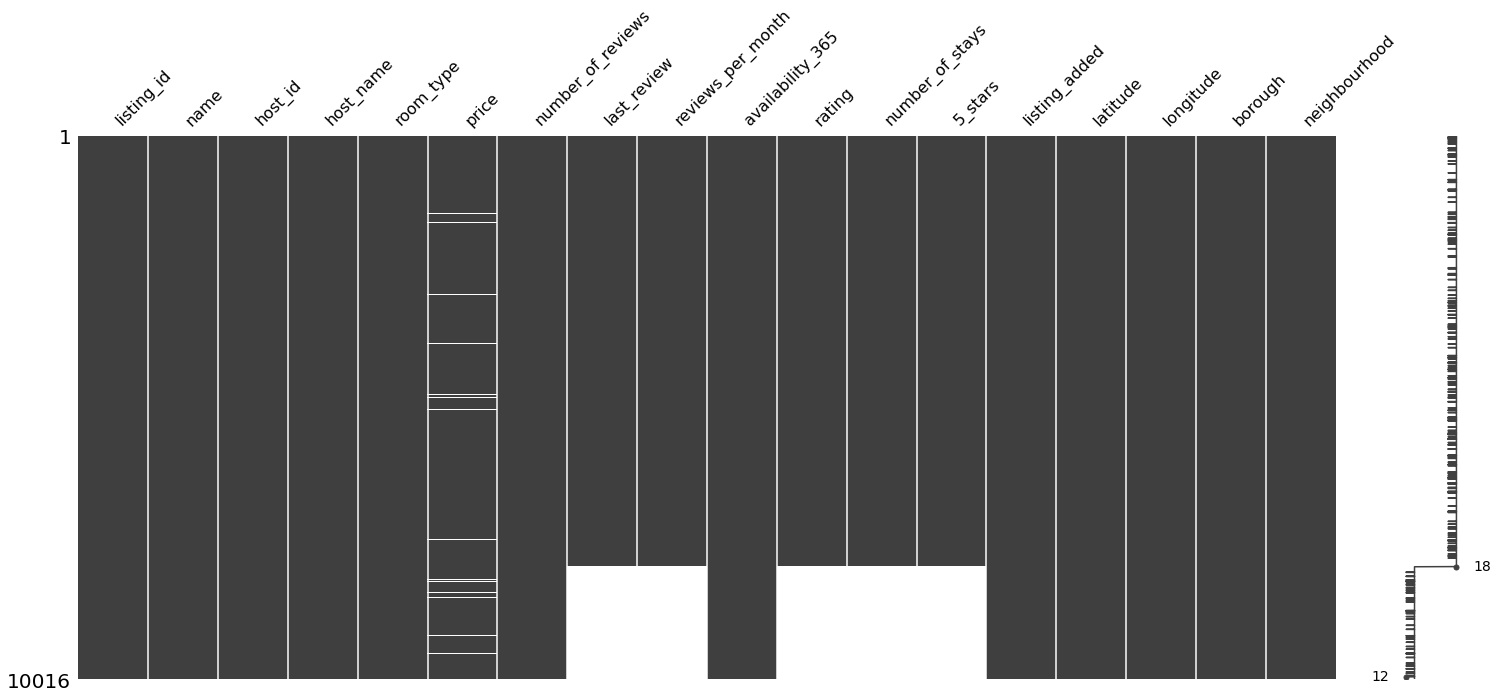

In [ ]:
# Visualize the missingness on sorted values
msno.matrix(airbnb.sort_values(by = 'rating'))
plt.show()

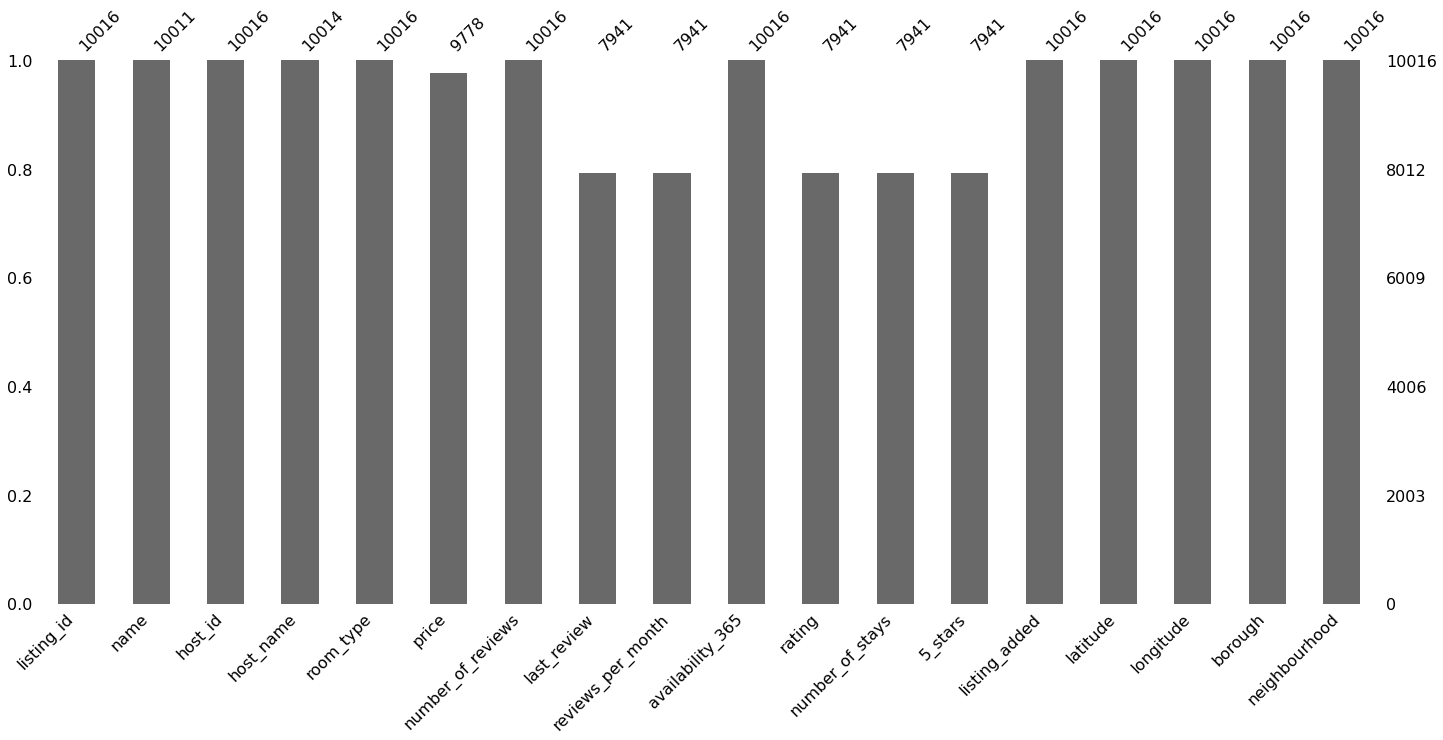

In [ ]:
# Missingness barplot
msno.bar(airbnb)

**Treating the** `rating`, `number_of_stays`, `5_stars`, `reviews_per_month` **columns**

In [ ]:
# Understand DataFrame with missing values in rating, number_of_stays, 5_stars, reviews_per_month
airbnb[airbnb['rating'].isna()].describe()

,listing_id,host_id,price,number_of_reviews,reviews_per_month,availability_365,rating,number_of_stays,5_stars,latitude,longitude
count,2.075000e+03,2.075000e+03,2028.000000,2075.0,0.0,2075.000000,0.0,0.0,0.0,2075.000000,2075.000000
mean,2.274238e+07,8.022455e+07,191.553748,0.0,NaN,104.531566,NaN,NaN,NaN,40.732074,-73.956771
std,1.123730e+07,8.663163e+07,316.186639,0.0,NaN,138.266525,NaN,NaN,NaN,0.051168,0.041065
min,6.358800e+04,1.475100e+04,0.000000,0.0,NaN,0.000000,NaN,NaN,NaN,40.527000,-74.209410
25%,1.232923e+07,1.224305e+07,70.000000,0.0,NaN,0.000000,NaN,NaN,NaN,40.697845,-73.985185
50%,2.345182e+07,4.040116e+07,120.000000,0.0,NaN,7.000000,NaN,NaN,NaN,40.727790,-73.960940
75%,3.400364e+07,1.333498e+08,205.250000,0.0,NaN,211.000000,NaN,NaN,NaN,40.763480,-73.939540
max,3.648724e+07,2.741034e+08,5250.000000,0.0,NaN,365.000000,NaN,NaN,NaN,40.911690,-73.727310


In [ ]:
# Understand DataFrame with missing values in rating, number_of_stays, 5_stars, reviews_per_month
airbnb[~airbnb['rating'].isna()].describe()

,listing_id,host_id,price,number_of_reviews,reviews_per_month,availability_365,rating,number_of_stays,5_stars,latitude,longitude
count,7.941000e+03,7.941000e+03,7750.000000,7941.000000,7941.000000,7941.000000,7941.000000,7941.000000,7941.000000,7941.000000,7941.000000
mean,1.836419e+07,6.474110e+07,140.230581,28.336482,1.353901,114.320111,4.014050,34.003778,0.718540,40.728335,-73.950632
std,1.068788e+07,7.606089e+07,163.630337,46.746949,1.615659,129.789313,0.574787,56.096338,0.079927,0.055491,0.047017
min,3.831000e+03,2.787000e+03,0.000000,1.000000,0.010000,0.000000,3.000633,1.200000,0.600026,40.508680,-74.239860
25%,8.964308e+06,7.138163e+06,69.000000,3.000000,0.200000,0.000000,3.519751,3.600000,0.655573,40.688560,-73.982130
50%,1.927436e+07,2.947846e+07,105.000000,9.000000,0.700000,54.000000,4.027415,10.800000,0.709747,40.721820,-73.954410
75%,2.787660e+07,1.016578e+08,170.000000,32.000000,2.000000,229.000000,4.515626,38.400000,0.763948,40.763390,-73.934930
max,3.635113e+07,2.733615e+08,8000.000000,510.000000,16.220000,365.000000,4.999561,612.000000,0.939950,40.913060,-73.719280


Looking at the missing data in the DataFrame - we can see that `number_of_reviews` across all missing rows is 0. We can infer that these listings have never been visited - hence could be inferred they're inactive/have never been visited.

We can impute them as following:

- Set `NaN` for `reviews_per_month`, `number_of_stays`, `5_stars` to 0.
- Since a `rating` did not happen, let's keep the column as is - but create a new column named `rated` that takes in `1` if yes, `0` if no.
- We will also leave `last_review` as is.


In [ ]:
# Impute missing data
airbnb = airbnb.fillna({'reviews_per_month':0,
                        'number_of_stays':0,
                        '5_stars':0})

# Create is_rated column
is_rated = np.where(airbnb['rating'].isna() == True, 0, 1)
airbnb['is_rated'] = is_rated

**Treating the** `price` **column**

In [ ]:
# Investigate DataFrame with missing values in price
airbnb[airbnb['price'].isna()].describe()

,listing_id,host_id,price,number_of_reviews,reviews_per_month,availability_365,rating,number_of_stays,5_stars,latitude,longitude,is_rated
count,2.380000e+02,2.380000e+02,0.0,238.000000,238.000000,238.000000,191.000000,238.000000,238.000000,238.000000,238.000000,238.000000
mean,1.805656e+07,6.262965e+07,NaN,22.445378,1.117563,98.953782,4.078343,26.934454,0.577721,40.727270,-73.946071,0.802521
std,1.065176e+07,7.518785e+07,NaN,35.798003,1.666262,125.872256,0.568705,42.957603,0.297066,0.057426,0.048688,0.398936
min,8.092400e+04,1.145900e+05,NaN,0.000000,0.000000,0.000000,3.007359,0.000000,0.000000,40.581980,-74.160620,0.000000
25%,8.282298e+06,6.034050e+06,NaN,1.000000,0.080000,0.000000,3.646496,1.200000,0.613462,40.688043,-73.970362,1.000000
50%,1.863600e+07,2.809524e+07,NaN,6.000000,0.350000,23.000000,4.149203,7.200000,0.681884,40.719925,-73.951370,1.000000
75%,2.753759e+07,1.009006e+08,NaN,26.000000,1.435000,192.000000,4.538671,31.200000,0.746239,40.762030,-73.927908,1.000000
max,3.638875e+07,2.668265e+08,NaN,207.000000,8.870000,365.000000,4.957646,248.400000,0.934979,40.870390,-73.734620,1.000000


In [ ]:
# Investigate DataFrame with missing values in price
airbnb[~airbnb['price'].isna()].describe()

,listing_id,host_id,price,number_of_reviews,reviews_per_month,availability_365,rating,number_of_stays,5_stars,latitude,longitude,is_rated
count,9.778000e+03,9.778000e+03,9778.00000,9778.000000,9778.000000,9778.000000,7750.000000,9778.000000,9778.000000,9778.000000,9778.000000,9778.000000
mean,1.930078e+07,6.807826e+07,150.87523,22.466558,1.072341,112.616895,4.012465,26.959869,0.569485,40.729154,-73.952046,0.792596
std,1.095415e+07,7.869506e+07,205.86666,43.344327,1.536549,131.769744,0.574882,52.013192,0.299870,0.054575,0.045837,0.405468
min,3.831000e+03,2.787000e+03,0.00000,0.000000,0.000000,0.000000,3.000633,0.000000,0.000000,40.508680,-74.239860,0.000000
25%,9.696668e+06,7.952219e+06,69.00000,1.000000,0.040000,0.000000,3.518948,1.200000,0.611644,40.689912,-73.983030,1.000000
50%,2.012299e+07,3.167018e+07,106.00000,5.000000,0.375000,44.500000,4.024327,6.000000,0.681882,40.723095,-73.955580,1.000000
75%,2.938694e+07,1.074344e+08,180.00000,22.000000,1.550000,227.750000,4.514427,26.400000,0.750110,40.763438,-73.936217,1.000000
max,3.648724e+07,2.741034e+08,8000.00000,510.000000,16.220000,365.000000,4.999561,612.000000,0.939950,40.913060,-73.719280,1.000000


From a common sense perspective, the most predictive factor for a room's price is the `room_type` column, so let's visualize how price varies by room type with `sns.boxplot()` which displays the following information:


<p align="center">
<img src="https://github.com/adelnehme/cleaning-data-in-python-live-training/blob/master/boxplot.png?raw=true" alt = "DataCamp icon" width="80%">
</p>




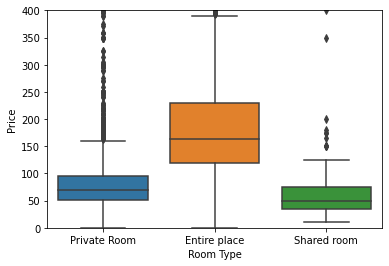

In [ ]:
# Visualize relationship between price and room_type
sns.boxplot(x = 'room_type', y = 'price', data = airbnb)
plt.ylim(0, 400)
plt.xlabel('Room Type')
plt.ylabel('Price')
plt.show()

In [ ]:
# Get median price per room_type
airbnb.groupby('room_type').median()['price']

room_type
Entire place    163.0
Private Room     70.0
Shared room      50.0
Name: price, dtype: float64

In [ ]:
# Impute price based on conditions
airbnb.loc[(airbnb['price'].isna()) & (airbnb['room_type'] == 'Entire place'), 'price'] = 163.0
airbnb.loc[(airbnb['price'].isna()) & (airbnb['room_type'] == 'Private Room'), 'price'] = 70.0
airbnb.loc[(airbnb['price'].isna()) & (airbnb['room_type'] == 'Shared Room'), 'price'] = 50.0

In [ ]:
# Confirm price has been imputed
airbnb.isna().sum()

listing_id              0
name                    5
host_id                 0
host_name               2
room_type               0
price                   7
number_of_reviews       0
last_review          2075
reviews_per_month       0
availability_365        0
rating               2075
number_of_stays         0
5_stars                 0
listing_added           0
latitude                0
longitude               0
borough                 0
neighbourhood           0
is_rated                0
dtype: int64

### What's still to be done?

Albeit we've done a significant amount of data cleaning tasks, there are still a couple of problems we have yet to diagnose. When cleaning data, we need to consider:

- Values that do not make any sense *(for example: are there values of `last_review` that older than `listing_added`? Are there listings in the future?*)
- Presence of duplicates values - and how to deal with them?

##### **Task 8:** Do we have consistent date data?

In [ ]:
# Doing some sanity checks on date data
today = dt.date.today()

In [ ]:
# Are there reviews in the future?
airbnb[airbnb['last_review'].dt.date > today]

,listing_id,name,host_id,host_name,room_type,price,number_of_reviews,last_review,reviews_per_month,availability_365,rating,number_of_stays,5_stars,listing_added,latitude,longitude,borough,neighbourhood,is_rated


In [ ]:
# Are there listings in the future?
airbnb[airbnb['listing_added'].dt.date > today]

,listing_id,name,host_id,host_name,room_type,price,number_of_reviews,last_review,reviews_per_month,availability_365,rating,number_of_stays,5_stars,listing_added,latitude,longitude,borough,neighbourhood,is_rated
4,22986519,Bedroom on the lively Lower East Side,154262349,Brooke,Private Room,160.0,23,2019-06-12,2.29,102,3.822591,27.6,0.649383,2020-10-23,40.71884,-73.98354,Manhattan,Lower East Side,1
124,28659894,Private bedroom in prime Bushwick! Near Trains!!!,216235179,Nina,Private Room,55.0,4,2019-04-12,0.58,358,4.916252,4.8,0.703117,2020-08-23,40.69988,-73.92072,Brooklyn,Bushwick,1
511,33619855,Modern & Spacious in trendy Crown Heights,253354074,Yehudis,Entire place,150.0,6,2019-05-27,2.50,148,3.462432,7.2,0.610929,2020-10-07,40.66387,-73.93840,Brooklyn,Crown Heights,1
521,25317793,Awesome Cozy Room in The Heart of Sunnyside!,136406167,Kara,Private Room,65.0,22,2019-06-11,1.63,131,4.442485,26.4,0.722388,2020-10-22,40.74090,-73.92696,Queens,Sunnyside,1


In [ ]:
# Drop these rows since they are only 4 rows
airbnb = airbnb[~(airbnb['listing_added'].dt.date > today)]

In [ ]:
# Are there any listings with listing_added > last_review
inconsistent_dates = airbnb[airbnb['listing_added'].dt.date > airbnb['last_review'].dt.date]
inconsistent_dates

,listing_id,name,host_id,host_name,room_type,price,number_of_reviews,last_review,reviews_per_month,availability_365,rating,number_of_stays,5_stars,listing_added,latitude,longitude,borough,neighbourhood,is_rated
50,20783900,Marvelous Manhattan Marble Hill Private Suites,148960265,Randy,Private Room,93.0,7,2018-10-06,0.32,0,4.868036,8.4,0.609263,2020-02-17,40.87618,-73.91266,Manhattan,Marble Hill,1
60,1908852,Oversized Studio By Columbus Circle,684629,Alana,Entire place,189.0,7,2016-05-06,0.13,0,4.841204,8.4,0.725995,2017-09-17,40.77060,-73.98919,Manhattan,Upper West Side,1


In [ ]:
# Drop these rows since they are only 2 rows
airbnb.drop(inconsistent_dates.index, inplace = True)

##### **Task 9:** Let's deal with duplicate data


There are two notable types of duplicate data:

- Identical duplicate data across all columns
- Identical duplicate data cross most or some columns

To diagnose, and deal with duplicate data, we will be using the following methods and functions:

- `.duplicated(subset = , keep = )`
  - `subset` lets us pick one or more columns with duplicate values.
  - `keep` returns lets us return all instances of duplicate values.
- `.drop_duplicates(subset = , keep = )`
  

In [ ]:
# Print the header of the DataFrame again
airbnb.head()

,listing_id,name,host_id,host_name,room_type,price,number_of_reviews,last_review,reviews_per_month,availability_365,rating,number_of_stays,5_stars,listing_added,latitude,longitude,borough,neighbourhood,is_rated
0,13740704,"Cozy,budget friendly, cable inc, private entra...",20583125,Michel,Private Room,45.0,10,2018-12-12,0.70,85,4.100954,12.0,0.609432,2018-06-08,40.63222,-73.93398,Brooklyn,Flatlands,1
1,22005115,Two floor apartment near Central Park,82746113,Cecilia,Entire place,135.0,1,2019-06-30,1.00,145,3.367600,1.2,0.746135,2018-12-25,40.78761,-73.96862,Manhattan,Upper West Side,1
2,21667615,Beautiful 1BR in Brooklyn Heights,78251,Leslie,Entire place,150.0,0,NaT,0.00,65,NaN,0.0,0.000000,2018-08-15,40.70070,-73.99517,Brooklyn,Brooklyn Heights,0
3,6425850,"Spacious, charming studio",32715865,Yelena,Entire place,86.0,5,2017-09-23,0.13,0,4.763203,6.0,0.769947,2017-03-20,40.79169,-73.97498,Manhattan,Upper West Side,1
5,271954,Beautiful brownstone apartment,1423798,Aj,Entire place,150.0,203,2019-06-20,2.22,300,4.478396,243.6,0.743500,2018-12-15,40.73388,-73.99452,Manhattan,Greenwich Village,1


In [ ]:
# Find duplicates
duplicates = airbnb.duplicated(subset = 'listing_id', keep = False)
print(duplicates)

0        False
1        False
2        False
3        False
5        False
         ...  
10014    False
10015    False
10016    False
10017    False
10018    False
Length: 10010, dtype: bool


In [ ]:
# Find duplicates
airbnb[duplicates].sort_values('listing_id')

,listing_id,name,host_id,host_name,room_type,price,number_of_reviews,last_review,reviews_per_month,availability_365,rating,number_of_stays,5_stars,listing_added,latitude,longitude,borough,neighbourhood,is_rated
1145,253806,Loft Suite @ The Box House Hotel,417504,The Box House Hotel,Entire place,199.0,43,2019-07-02,0.47,60,4.620238,51.6,0.861086,2018-12-27,40.73652,-73.95236,Brooklyn,Greenpoint,1
6562,253806,Loft Suite @ The Box House Hotel,417504,The Box House Hotel,Entire place,199.0,43,2019-07-02,0.47,60,4.620238,51.6,0.861086,2018-12-27,40.73652,-73.95236,Brooklyn,Greenpoint,1
8699,2044392,The heart of Williamsburg 2 bedroom,620218,Sarah,Entire place,245.0,0,NaT,0.00,0,NaN,0.0,0.000000,2018-08-09,40.71257,-73.96149,Brooklyn,Williamsburg,0
5761,2044392,The heart of Williamsburg 2 bedroom,620218,Sarah,Entire place,250.0,0,NaT,0.00,0,NaN,0.0,0.000000,2018-05-24,40.71257,-73.96149,Brooklyn,Williamsburg,0
4187,4244242,Best Bedroom in Bedstuy/Bushwick. Ensuite bath...,22023014,BrooklynSleeps,Private Room,73.0,110,2019-06-23,1.96,323,4.962314,132.0,0.809882,2018-12-18,40.69496,-73.93949,Brooklyn,Bedford-Stuyvesant,1
2871,4244242,Best Bedroom in Bedstuy/Bushwick. Ensuite bath...,22023014,BrooklynSleeps,Private Room,70.0,110,2019-06-23,1.96,323,4.962314,132.0,0.809882,2018-12-18,40.69496,-73.93949,Brooklyn,Bedford-Stuyvesant,1
77,7319856,450ft Square Studio in Gramercy NY,11773680,Adam,Entire place,289.0,4,2016-05-22,0.09,225,3.903764,4.8,0.756381,2015-11-17,40.73813,-73.98098,Manhattan,Kips Bay,1
2255,7319856,450ft Square Studio in Gramercy NY,11773680,Adam,Entire place,280.0,4,2016-05-22,0.09,225,3.903764,4.8,0.756381,2015-11-17,40.73813,-73.98098,Manhattan,Kips Bay,1
555,9078222,"Prospect Park 3 bdrm, Sleeps 8 (#2)",47219962,Babajide,Entire place,154.0,123,2019-07-01,2.74,263,3.466881,147.6,0.738191,2018-12-26,40.66086,-73.96159,Brooklyn,Prospect-Lefferts Gardens,1
7933,9078222,"Prospect Park 3 bdrm, Sleeps 8 (#2)",47219962,Babajide,Entire place,150.0,123,2019-07-01,2.74,263,3.466881,147.6,0.738191,2018-12-26,40.66086,-73.96159,Brooklyn,Prospect-Lefferts Gardens,1


In [ ]:
# Remove identical duplicates
airbnb = airbnb.drop_duplicates()

In [ ]:
# Find non-identical duplicates
duplicates = airbnb.duplicated(subset = 'listing_id', keep = False)

In [ ]:
# Show all duplicates
airbnb[duplicates].sort_values('listing_id')

,listing_id,name,host_id,host_name,room_type,price,number_of_reviews,last_review,reviews_per_month,availability_365,rating,number_of_stays,5_stars,listing_added,latitude,longitude,borough,neighbourhood,is_rated
5761,2044392,The heart of Williamsburg 2 bedroom,620218,Sarah,Entire place,250.0,0,NaT,0.00,0,NaN,0.0,0.000000,2018-05-24,40.71257,-73.96149,Brooklyn,Williamsburg,0
8699,2044392,The heart of Williamsburg 2 bedroom,620218,Sarah,Entire place,245.0,0,NaT,0.00,0,NaN,0.0,0.000000,2018-08-09,40.71257,-73.96149,Brooklyn,Williamsburg,0
2871,4244242,Best Bedroom in Bedstuy/Bushwick. Ensuite bath...,22023014,BrooklynSleeps,Private Room,70.0,110,2019-06-23,1.96,323,4.962314,132.0,0.809882,2018-12-18,40.69496,-73.93949,Brooklyn,Bedford-Stuyvesant,1
4187,4244242,Best Bedroom in Bedstuy/Bushwick. Ensuite bath...,22023014,BrooklynSleeps,Private Room,73.0,110,2019-06-23,1.96,323,4.962314,132.0,0.809882,2018-12-18,40.69496,-73.93949,Brooklyn,Bedford-Stuyvesant,1
77,7319856,450ft Square Studio in Gramercy NY,11773680,Adam,Entire place,289.0,4,2016-05-22,0.09,225,3.903764,4.8,0.756381,2015-11-17,40.73813,-73.98098,Manhattan,Kips Bay,1
2255,7319856,450ft Square Studio in Gramercy NY,11773680,Adam,Entire place,280.0,4,2016-05-22,0.09,225,3.903764,4.8,0.756381,2015-11-17,40.73813,-73.98098,Manhattan,Kips Bay,1
555,9078222,"Prospect Park 3 bdrm, Sleeps 8 (#2)",47219962,Babajide,Entire place,154.0,123,2019-07-01,2.74,263,3.466881,147.6,0.738191,2018-12-26,40.66086,-73.96159,Brooklyn,Prospect-Lefferts Gardens,1
7933,9078222,"Prospect Park 3 bdrm, Sleeps 8 (#2)",47219962,Babajide,Entire place,150.0,123,2019-07-01,2.74,263,3.466881,147.6,0.738191,2018-12-26,40.66086,-73.96159,Brooklyn,Prospect-Lefferts Gardens,1
1481,15027024,Newly renovated 1bd on lively & historic St Marks,8344620,Ethan,Entire place,180.0,10,2018-12-31,0.30,0,3.969729,12.0,0.772513,2018-06-27,40.72693,-73.98385,Manhattan,East Village,1
3430,15027024,Newly renovated 1bd on lively & historic St Marks,8344620,Ethan,Entire place,180.0,10,2018-12-31,0.30,0,3.869729,12.0,0.772513,2018-06-27,40.72693,-73.98385,Manhattan,East Village,1


To treat identical duplicates across some columns, we will chain the `.groupby()` and `.agg()` methods where we group by the column used to find duplicates (`listing_id`) and aggregate across statistical measures for `price`, `rating` and `list_added`. The `.agg()` method takes in a dictionary with each column's aggregation method - we will use the following aggregations:

- `mean` for `price` and `rating` columns
- `max` for `listing_added` column
- `first` for all remaining column

*A note on dictionary comprehensions:*

Dictionaries are useful data structures in Python with the following format
`my_dictionary = {key: value}` where a `key` is mapped to a `value` and whose `value` can be returned with `my_dictionary[key]` - dictionary comprehensions allow us to programmatically create dicitonaries using the structure:

```
{x: x*2 for x in [1,2,3,4,5]}
{1:2, 2:4, 3:6, 4:8, 5:10}
```

In [ ]:
# Get column names from airbnb
column_names = airbnb.columns
column_names

Index(['listing_id', '5_stars', 'availability_365', 'borough', 'host_id',
       'host_name', 'is_rated', 'last_review', 'latitude', 'longitude', 'name',
       'neighbourhood', 'number_of_reviews', 'number_of_stays',
       'reviews_per_month', 'room_type', 'price', 'rating', 'listing_added'],
      dtype='object')

In [ ]:
# Create dictionary comprehension with 'first' as value for all columns not being aggregated
aggregations = {column_name:'first' for column_name in column_names.difference(['listing_id', 'listing_added', 'rating', 'price'])}
aggregations['price'] = 'mean'
aggregations['rating'] = 'mean'
aggregations['listing_added'] = 'max'
aggregations

{'5_stars': 'first',
 'availability_365': 'first',
 'borough': 'first',
 'host_id': 'first',
 'host_name': 'first',
 'is_rated': 'first',
 'last_review': 'first',
 'latitude': 'first',
 'listing_added': 'max',
 'longitude': 'first',
 'name': 'first',
 'neighbourhood': 'first',
 'number_of_reviews': 'first',
 'number_of_stays': 'first',
 'price': 'mean',
 'rating': 'mean',
 'reviews_per_month': 'first',
 'room_type': 'first'}

In [ ]:
# Remove non-identical duplicates
airbnb = airbnb.groupby('listing_id').agg(aggregations).reset_index()

In [ ]:
# Make sure no duplication happened
airbnb[airbnb.duplicated('listing_id', keep = False)]

,listing_id,5_stars,availability_365,borough,host_id,host_name,is_rated,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,number_of_stays,reviews_per_month,room_type,price,rating,listing_added


In [ ]:
# Print header of DataFrame
airbnb.head()

,listing_id,5_stars,availability_365,borough,host_id,host_name,is_rated,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,number_of_stays,reviews_per_month,room_type,price,rating,listing_added
0,3831,0.757366,194,Brooklyn,4869,LisaRoxanne,1,2019-07-05,40.68514,-73.95976,Cozy Entire Floor of Brownstone,Clinton Hill,270,324.0,4.64,Entire place,89.0,3.273935,2018-12-30
1,6848,0.789743,46,Brooklyn,15991,Allen & Irina,1,2019-06-29,40.70837,-73.95352,Only 2 stops to Manhattan studio,Williamsburg,148,177.6,1.20,Entire place,140.0,3.495760,2018-12-24
2,7322,0.669873,12,Manhattan,18946,Doti,1,2019-07-01,40.74192,-73.99501,Chelsea Perfect,Chelsea,260,312.0,2.12,Private Room,140.0,4.389051,2018-12-26
3,7726,0.640251,21,Brooklyn,20950,Adam And Charity,1,2019-06-22,40.67592,-73.94694,Hip Historic Brownstone Apartment with Backyard,Crown Heights,53,63.6,4.44,Entire place,99.0,3.305382,2018-12-17
4,12303,0.918593,311,Brooklyn,47618,Yolande,1,2018-09-30,40.69673,-73.97584,1bdr w private bath. in lofty apt,Fort Greene,25,30.0,0.23,Private Room,120.0,4.568745,2018-03-27


## **Q&A**

### Take home question

Try to answer the following questions about the dataset:

- What is the average price of listings by borough? Visualize your results with a bar plot!
- What is the average availability in days of listings by borough? Visualize your results with a bar plot!
- What is the median price per room type in each borough? Visualize your results with a bar plot!
- Visualize the number of listings over time.

**Functions that should/could be used:**
- `.groupby()` and `.agg(})`
- `sns.barplot(x = , y = , hue = , data = )`
- `sns.lineplot(x = , y = , data = )`
- `.dt.strftime()` for extracting specific dates from a `datetime` column

**Bonus points if:**
- You finish more than one question

**Submission details:**
- Share with us a code snippet with your output on LinkedIn, Twitter or Facebook
- Tag us on `@DataCamp` with the hashtag `#datacamplive`
